In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import sys
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import os
import csv
from helpers.outliers import MyOutliers
from skroutz_mobile import SkroutzMobile
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from skroutz_mobile import SkroutzMobile
from sklearn.model_selection import StratifiedShuffleSplit
from helpers.my_train_test_split import MySplitTrainTest
from sklearn.preprocessing import StandardScaler
from preprocess_price_history import PreprocessPriceHistory
from price_history import PriceHistory
%matplotlib inline

In [3]:
random_state = np.random.RandomState(seed=16011984)

In [4]:
csv_in = "../price_history_01_no_spikes.csv"
csv_middle = "../price_history_02_with_seq_start.csv"
csv_out = "../price_history_03_standardized.csv"

In [5]:
df = pd.read_csv(csv_in, index_col=0, encoding='utf-8', quoting=csv.QUOTE_ALL)

In [6]:
df_with_seq_start = PreprocessPriceHistory.createSeqStartColumnOutOfOriginalPrices(df=df)
#df_with_seq_start.to_csv(csv_middle, encoding='utf-8', quoting=csv.QUOTE_ALL)
df_with_seq_start['seq_start']

10084353    472
7653378     472
8617989     470
9615369     379
8212493     466
8491027     472
11718680    626
7562927     338
10010654    563
5539871     466
8742945     472
8874019     438
9672740     479
10536998    487
12198699    680
8095786     464
10742791    515
11159597    571
9517102     471
10680367    506
9877558     410
11057217    561
9500739     469
10977348    553
11067464    562
10010698    525
7219275     471
8212556     358
10242128    465
9501836     471
           ... 
8648639     473
8984512     473
9561760     472
6756290     386
10000323    473
10644470    500
11617813    616
11201527    578
10620877    498
11222349    602
10774486    665
11448281    598
11181013    576
6918108     412
9304030     473
6757029     473
9517024     471
8385872     471
9672674     473
11860310    644
10555365    518
6666214     472
10297324    467
9815037     472
10766323    611
9815038     662
11087863    597
10065912    472
9824249     472
9875453     472
Name: seq_start, Length:

In [7]:
df_norm = PreprocessPriceHistory.convertToPriceDifferences(df=df_with_seq_start)
df_norm.shape

(837, 684)

In [8]:
#df_norm.to_csv(csv_out, encoding='utf-8', quoting=csv.QUOTE_ALL)

In [31]:
df_norm_prices = df_norm.drop(labels=PriceHistory.SPECIAL_COLS, axis=1)
df_norm_prices.shape

(837, 682)

In [32]:
flatvals = df_norm_prices.values.flatten()
flatvals.shape

(570834,)

In [34]:
np.all(flatvals[682:682*2] == df_norm_prices.values[1])

True

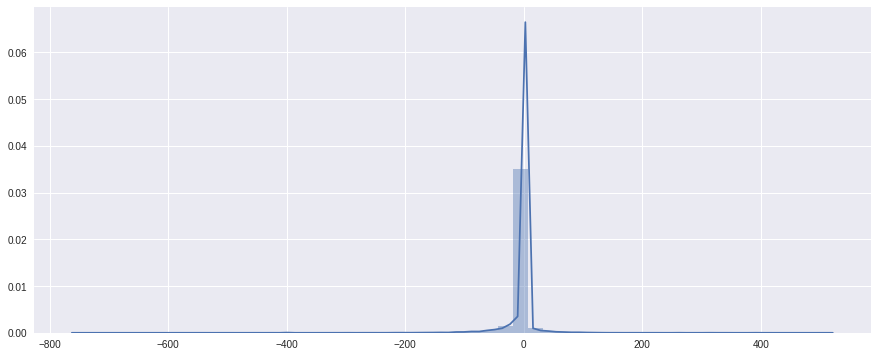

In [35]:
plt.figure(figsize=(15,6))
sns.distplot(flatvals)
plt.show()

In [46]:
std = np.std(flatvals)
std

25.116962448782928

In [47]:
np.mean(flatvals)

-2.617446017581293

Trust only up to three standard deviations.  
Which is expected, ~75 euros difference from the original price is the maximum of what
normally see as a customer

In [64]:
stds_threshold = std*3
stds_threshold

75.350887346348784

In [65]:
min(df_norm_prices.iloc[0])

-32.969999999999999

#### this is to trim according to minimum and maximum value

In [63]:
keep_inds = [ii for ii in range(len(df_norm_prices))
     if max(df_norm_prices.iloc[ii]) < stds_threshold and 
             -stds_threshold < min(df_norm_prices.iloc[ii])
    ]
len(keep_inds)

619

#### another idea is to trim according to the rate of change

In [84]:
keep_inds = [ii for ii in range(len(df_norm_prices))
     if np.all(
            np.absolute(df_norm_prices.iloc[ii][1:] - 
                np.roll(df_norm_prices.iloc[ii], 1)[1:]) < stds_threshold
        )
    ]
len(keep_inds)

689

#### and indeed those changing more than 75 euros / day are outliers
#### TODO maybe later we can filter those when choosing windows directly, because now we neglect entire time series

In [86]:
df_seq_start_trimmed = df_with_seq_start.iloc[keep_inds]
df_seq_start_trimmed.shape

(689, 684)

In [88]:
flatvals2 = df_norm_prices.iloc[keep_inds].values.flatten()
len(flatvals2)

469898

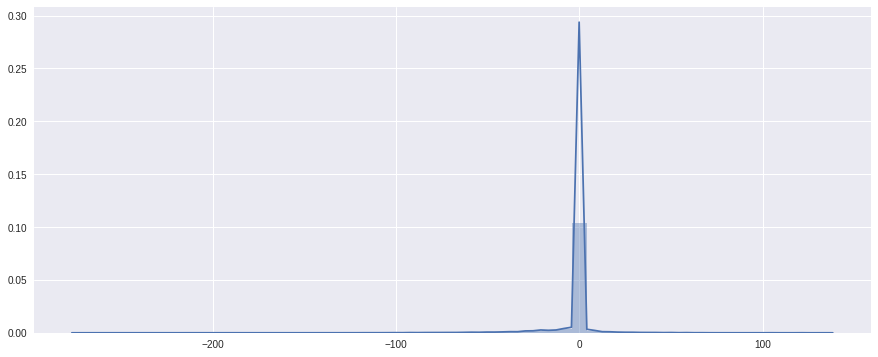

In [89]:
plt.figure(figsize=(15,6))
sns.distplot(flatvals2)
plt.show()

In [91]:
csv_path = "../price_history_03_seq_start_suddens_trimmed.csv"

In [93]:
df_seq_start_trimmed.to_csv(csv_path, encoding='utf-8', quoting=csv.QUOTE_ALL)